# Perigee Variables

**Goal:** Add in some of the perigee information into the network and see if this helps DIPS's performance

In [1]:
import numpy as np
import h5py
import sys
import os
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import * #myLSTM, myPFN
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Load in data and models and make roc curves

In [2]:
dataDir = "../../data/"
modelDir = "../../models/"
figDir = "../../figures/"

dense_sizes = [100] * 3
ppm_sizes = [100,100,128]

In [3]:
subDir_pf = "mc16d_PFlow_ttbar"
subDir_jf = subDir_pf + "_jf"

Initialize method from myModel()
Instructions for updating:
Colocations handled automatically by placer.
weightFile ../../models/mc16d_PFlow_ttbar_pt_0.5_d0_3.5_z0_5.0/DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


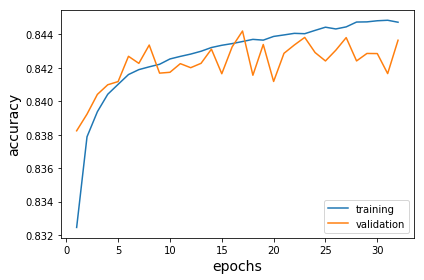

../../models/mc16d_PFlow_ttbar_pt_0.5_d0_3.5_z0_5.0/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_jf/DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_d0_z0_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


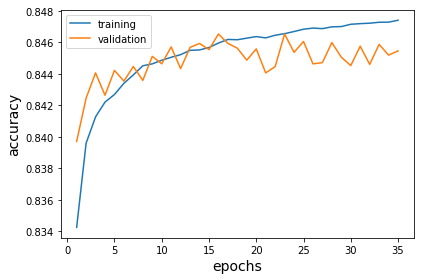

../../models/mc16d_PFlow_ttbar_jf/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_d0_z0.json
Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_jf/DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_d0_z0_phi_theta_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


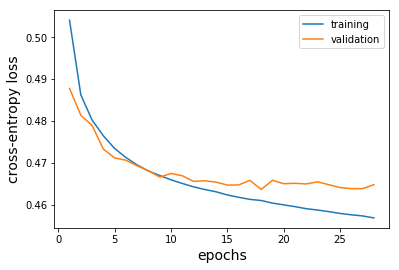

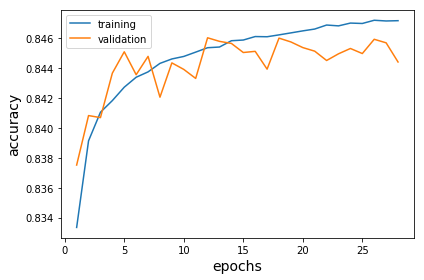

../../models/mc16d_PFlow_ttbar_jf/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_d0_z0_phi_theta.json
Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_jf/DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_d0_z0_phi_theta_qOverP_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


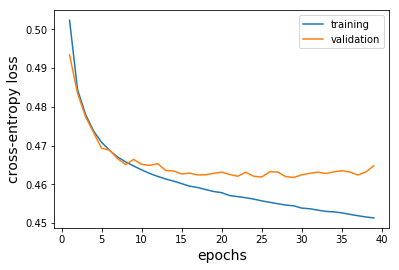

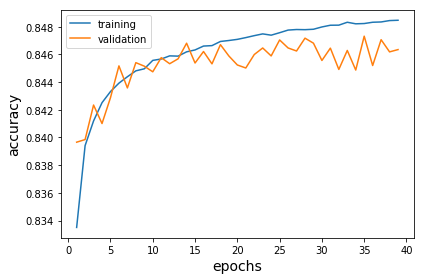

../../models/mc16d_PFlow_ttbar_jf/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_d0_z0_phi_theta_qOverP.json
Load in the previously saved efficiency file


In [4]:
leffs, ceffs, beffs = [],[],[]

nTrks=40
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"

sortFlags = ["abs_sd0_rev"] + ["sd0_rev"] * 3
tags = ["_pt_0.5_d0_3.5_z0_5.0"] + ["_jf"] * 3

for extraVars, sortFlag, tag in zip(['','_d0_z0','_phi_theta','_qOverP'],sortFlags, tags):
    
    
    vStr += extraVars
    
    dataTagTrain = "3mtrain_{}trks_{}".format(nTrks, vStr)
    dataTagTest  = "2mtest_{}trks_{}_{}".format(nTrks, vStr, sortFlag)
    
    '''
    Load in the data
    '''
    subDir = subDir_pf+tag
    f_name = "{}/{}/data_{}.hdf5".format(dataDir,subDir,dataTagTest)
    f = h5py.File(f_name,"r")

    X = f['X_test'][:]
    y = f['y_test'][:]
    ix = f['ix_test'][:]

    f.close()
    
    nFeatures = X.shape[-1]
    
    '''
    Load in the model
    '''
    dips = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
                modelDir=modelDir+subDir, dataTag=dataTagTrain, nClasses=3, 
                loadModel=True, dropout=0,batch_norm=True)
    
    trainingMetrics(dips.modelName, modelDir+subDir)
    
    '''
    Evaluate the taggers
    '''
    leff, ceff, beff = getEffs(dips, X, y, ix, figDir=figDir,
                               subDir=subDir, modelDir=modelDir+subDir)
    leffs.append(leff)
    ceffs.append(ceff)
    beffs.append(beff)
            

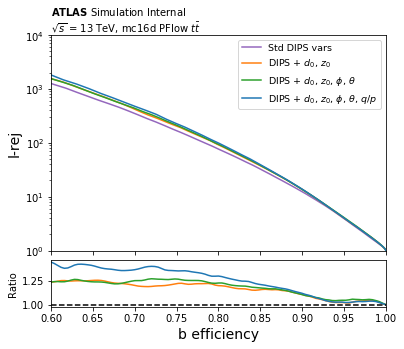

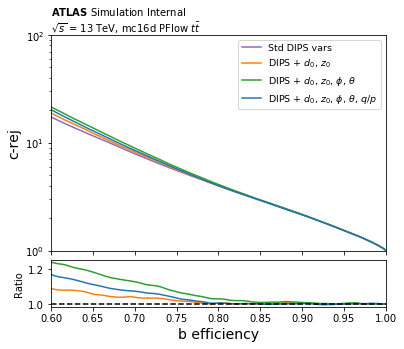

In [7]:
text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"$\sqrt{s}$ = 13 TeV, mc16d PFlow $t\bar{t}$"

colors = ['C4','C1','C2','C0']

labels = ['Std DIPS vars',
          'DIPS + $d_0$, $z_0$',
          r'DIPS + $d_0$, $z_0$, $\phi$, $\theta$',
          r'DIPS + $d_0$, $z_0$, $\phi$, $\theta$, $q/p$']

plotROCRatio(beffs, leffs, labels,text=text,colors=colors,
             legFontSize=9.5,ylabel='l-rej',ymax=1e4,
             figDir=figDir,subDir=subDir_jf,tag='lrej_perigeeVars')
plotROCRatio(beffs, ceffs, labels,text=text,colors=colors,
             legFontSize=9.5,ylabel='c-rej',ymax=100,
             figDir=figDir,subDir=subDir_jf,tag='crej_perigeeVars')